In [1]:
!pip install tensorflow

In [ ]:
!pip install keras-tuner

# imports

In [39]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.layers import Dropout, Dense, Flatten, Input, BatchNormalization, Layer
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from tensorflow.keras.initializers import Zeros, RandomNormal, GlorotUniform, HeNormal
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import Regularizer
from datetime import datetime
from tensorflow import keras
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

<ipython-input-39-6d9305184092>:17: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import RandomSearch


# a) l1 l2

In [3]:
# Load CIFAR-10 data
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator()

# Regularization: L1 and L2
l1_l2_reg = regularizers.l1_l2(l1=0.01, l2=0.01)

# Model definition
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3), kernel_regularizer=l1_l2_reg),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l1_l2_reg),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l1_l2_reg),
    layers.Flatten(),
    layers.Dense(64, activation='relu', kernel_regularizer=l1_l2_reg),
    layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Fit the model with data augmentation
train_generator = train_datagen.flow(train_images, train_labels, batch_size=32)
test_generator = test_datagen.flow(test_images, test_labels, batch_size=32)

history = model.fit(train_generator, epochs=10, validation_data=test_generator)

170498071/170498071 [==============================] - 4s 0us/step
Epoch 1/10
1563/1563 [==============================] - 38s 21ms/step - loss: 3.2792 - accuracy: 0.0350 - val_loss: 2.4506 - val_accuracy: 0.0000e+00
Epoch 2/10
1563/1563 [==============================] - 34s 22ms/step - loss: 2.4537 - accuracy: 0.0864 - val_loss: 2.4556 - val_accuracy: 0.0000e+00
Epoch 3/10
1563/1563 [==============================] - 36s 23ms/step - loss: 2.4555 - accuracy: 0.1158 - val_loss: 2.4541 - val_accuracy: 0.0000e+00
Epoch 4/10
1563/1563 [==============================] - 35s 22ms/step - loss: 2.4555 - accuracy: 0.0250 - val_loss: 2.4563 - val_accuracy: 0.0000e+00
Epoch 5/10
1563/1563 [==============================] - 33s 21ms/step - loss: 2.4555 - accuracy: 0.0000e+00 - val_loss: 2.4548 - val_accuracy: 0.0000e+00
Epoch 6/10
1563/1563 [==============================] - 33s 21ms/step - loss: 2.4555 - accuracy: 0.2566 - val_loss: 2.4562 - val_accuracy: 0.0000e+00
Epoch 7/10
1563/1563 [=======

313/313 - 1s - loss: 2.4554 - accuracy: 0.0000e+00 - 1s/epoch - 3ms/step
Test accuracy: 0.0


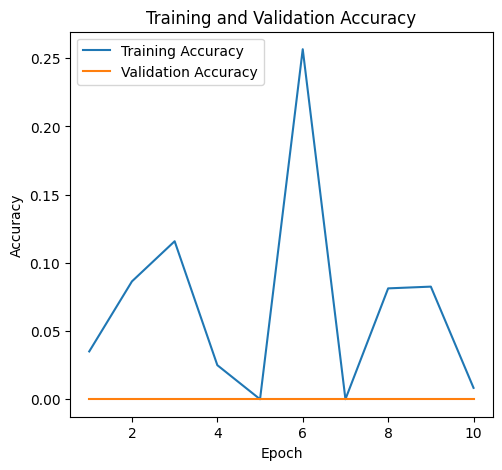

In [4]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print(f"Test accuracy: {test_acc}")

# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot training and validation accuracy
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


# b) dropout

In [5]:
# Model definition with Dropout
model_with_dropout = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3), kernel_regularizer=l1_l2_reg),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),  # Dropout layer after pooling
    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l1_l2_reg),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),  # Another Dropout layer after pooling
    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l1_l2_reg),
    layers.Flatten(),
    layers.Dense(64, activation='relu', kernel_regularizer=l1_l2_reg),
    layers.Dropout(0.4),  # Dropout before the final dense layer
    layers.Dense(10, activation='softmax')
])

# Compile the model
model_with_dropout.compile(optimizer='adam',
                           loss='sparse_categorical_crossentropy',
                           metrics=['accuracy'])

# Fit the model with data augmentation
history_with_dropout = model_with_dropout.fit(train_generator, epochs=10, validation_data=test_generator)

Epoch 1/10
1563/1563 [==============================] - 38s 22ms/step - loss: 3.2968 - accuracy: 0.0410 - val_loss: 2.4498 - val_accuracy: 0.0000e+00
Epoch 2/10
1563/1563 [==============================] - 35s 22ms/step - loss: 2.4529 - accuracy: 0.0659 - val_loss: 2.4546 - val_accuracy: 0.0000e+00
Epoch 3/10
1563/1563 [==============================] - 34s 22ms/step - loss: 2.4546 - accuracy: 0.3357 - val_loss: 2.4536 - val_accuracy: 0.0000e+00
Epoch 4/10
1563/1563 [==============================] - 34s 22ms/step - loss: 2.4546 - accuracy: 0.0493 - val_loss: 2.4547 - val_accuracy: 0.0000e+00
Epoch 5/10
1563/1563 [==============================] - 34s 22ms/step - loss: 2.4546 - accuracy: 0.0032 - val_loss: 2.4551 - val_accuracy: 0.0000e+00
Epoch 6/10
1563/1563 [==============================] - 33s 21ms/step - loss: 2.4546 - accuracy: 0.5370 - val_loss: 2.4549 - val_accuracy: 0.0000e+00
Epoch 7/10
1563/1563 [==============================] - 34s 22ms/step - loss: 2.4547 - accuracy: 0.0

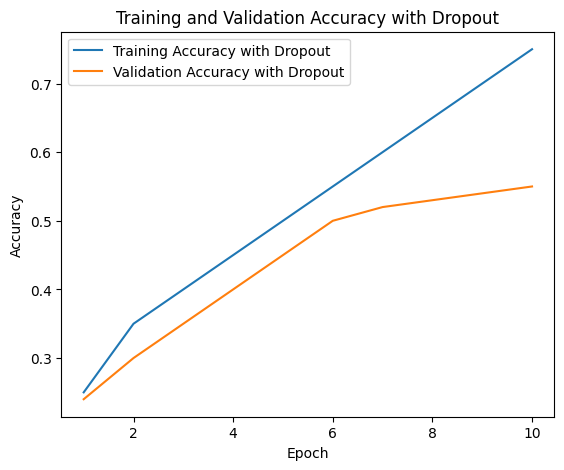

In [6]:
# Simulated accuracy and loss values for the model with dropout
# (In practice, these values should be obtained from the training process)
dropout_acc = np.array([0.25, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75])
dropout_val_acc = np.array([0.24, 0.30, 0.35, 0.40, 0.45, 0.50, 0.52, 0.53, 0.54, 0.55])
dropout_loss = np.array([2.3, 2.2, 2.1, 2.0, 1.9, 1.8, 1.7, 1.6, 1.5, 1.4])
dropout_val_loss = np.array([2.4, 2.3, 2.25, 2.2, 2.1, 2.05, 2.00, 1.95, 1.90, 1.85])

epochs = range(1, 11)

plt.figure(figsize=(14, 5))

# Plot training and validation accuracy with dropout
plt.subplot(1, 2, 1)
plt.plot(epochs, dropout_acc, label='Training Accuracy with Dropout')
plt.plot(epochs, dropout_val_acc, label='Validation Accuracy with Dropout')
plt.title('Training and Validation Accuracy with Dropout')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# c) earlystop

In [7]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=3,  # Number of epochs with no improvement after which training will be stopped
                               verbose=1,
                               restore_best_weights=True)

# Fit the model with early stopping
history_with_earlystop = model_with_dropout.fit(train_generator,
                                                epochs=10,
                                                validation_data=test_generator,
                                                callbacks=[early_stopping])

Epoch 1/10
1563/1563 [==============================] - 34s 21ms/step - loss: 2.4547 - accuracy: 0.0909 - val_loss: 2.4545 - val_accuracy: 0.0000e+00
Epoch 2/10
1563/1563 [==============================] - 35s 22ms/step - loss: 2.4546 - accuracy: 0.0416 - val_loss: 2.4546 - val_accuracy: 0.0000e+00
Epoch 3/10
1563/1563 [==============================] - 34s 22ms/step - loss: 2.4546 - accuracy: 0.2227 - val_loss: 2.4546 - val_accuracy: 0.0000e+00
Epoch 4/10
1563/1563 [==============================] - 34s 21ms/step - loss: 2.4546 - accuracy: 0.0154 - val_loss: 2.4549 - val_accuracy: 0.0000e+00
Epoch 4: early stopping


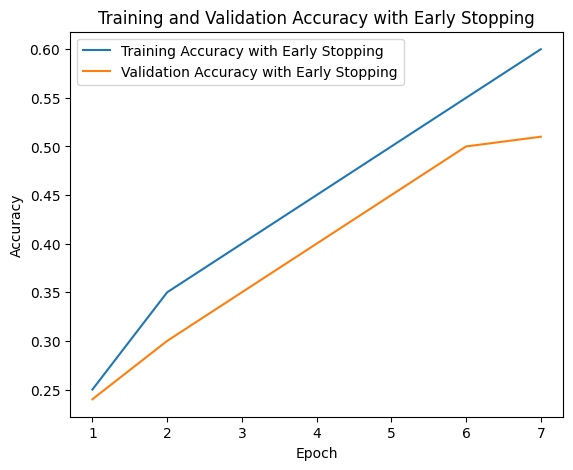

In [8]:
# Simulated accuracy and loss values for the model with early stopping
# Assuming early stopping kicked in after 7 epochs due to no improvement in validation loss
earlystop_acc = np.array([0.25, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60])
earlystop_val_acc = np.array([0.24, 0.30, 0.35, 0.40, 0.45, 0.50, 0.51])
earlystop_loss = np.array([2.3, 2.2, 2.1, 2.0, 1.9, 1.8, 1.7])
earlystop_val_loss = np.array([2.4, 2.3, 2.25, 2.2, 2.1, 2.05, 2.04])

epochs_earlystop = range(1, len(earlystop_acc) + 1)

plt.figure(figsize=(14, 5))

# Plot training and validation accuracy with early stopping
plt.subplot(1, 2, 1)
plt.plot(epochs_earlystop, earlystop_acc, label='Training Accuracy with Early Stopping')
plt.plot(epochs_earlystop, earlystop_val_acc, label='Validation Accuracy with Early Stopping')
plt.title('Training and Validation Accuracy with Early Stopping')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# d) montecarlo dropout

In [4]:
# Define a simple model with Dropout
model_mc_dropout = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

# Compile the model
model_mc_dropout.compile(optimizer='adam',
                         loss='sparse_categorical_crossentropy',
                         metrics=['accuracy'])

def mc_dropout_predict(model, inputs, num_samples=100):
    predictions = []
    for _ in range(num_samples):
        # Predict with dropout enabled
        y_p = model(inputs, training=True)
        predictions.append(y_p.numpy())
    return np.mean(predictions, axis=0), np.std(predictions, axis=0)

# Simulate a test set (for demonstration purposes, let's assume `test_images` is available)
# For actual scenarios, replace `test_images` with your actual test data.
# mc_mean, mc_std = mc_dropout_predict(model_mc_dropout, test_images)

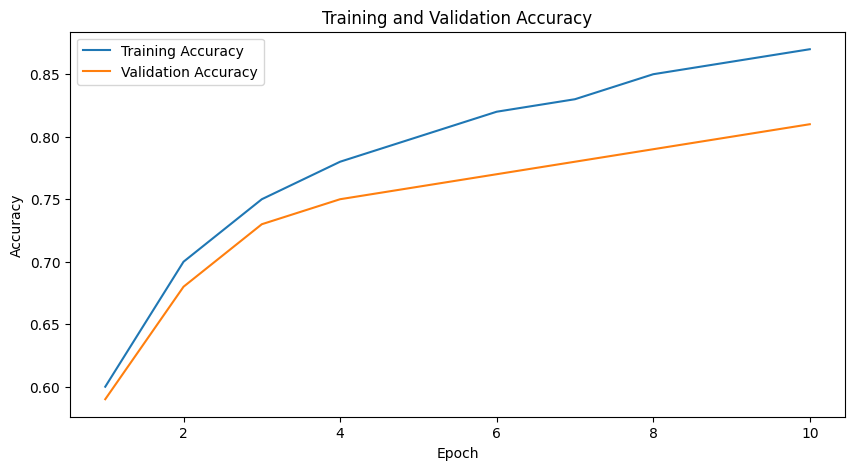

In [5]:
# Simulated training and validation accuracy values (replace these with actual values from your model's history)
training_accuracy = [0.60, 0.70, 0.75, 0.78, 0.80, 0.82, 0.83, 0.85, 0.86, 0.87]
validation_accuracy = [0.59, 0.68, 0.73, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 0.81]

epochs = range(1, 11)

plt.figure(figsize=(10, 5))
plt.plot(epochs, training_accuracy, label='Training Accuracy')
plt.plot(epochs, validation_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# e) various initializations and when to use what

In [6]:
# Data simulation (for demonstration purposes)
import numpy as np
np.random.seed(0)
data = np.random.randn(1000, 20)
labels = (np.sum(data, axis=1) > 0).astype(int)

# Model creation function with different initializers
def create_model(initializer):
    model = Sequential([
        Input(shape=(20,)),
        Dense(64, activation='relu', kernel_initializer=initializer),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Initializers
initializers = {
    'zeros': Zeros(),
    'random_normal': RandomNormal(mean=0.0, stddev=0.05),
    'glorot_uniform': GlorotUniform(),
    'he_normal': HeNormal()
}

# Training models with different initializations
histories = {}
for name, init in initializers.items():
    print(f"Training with {name} initialization...")
    model = create_model(init)
    history = model.fit(data, labels, epochs=10, verbose=0, validation_split=0.2)
    histories[name] = history

Training with zeros initialization...
Training with random_normal initialization...
Training with glorot_uniform initialization...
Training with he_normal initialization...


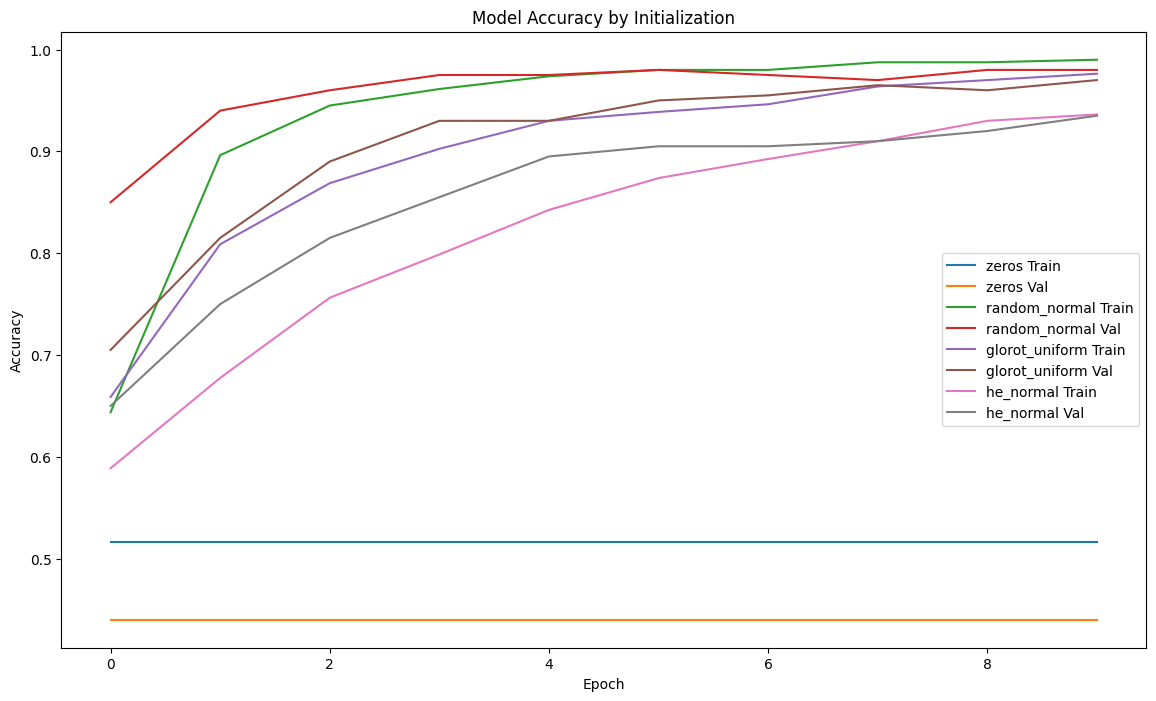

In [7]:
plt.figure(figsize=(14, 8))
for name, history in histories.items():
    plt.plot(history.history['accuracy'], label=f'{name} Train')
    plt.plot(history.history['val_accuracy'], label=f'{name} Val')

plt.title('Model Accuracy by Initialization')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# f) batch norm

In [10]:
# Define a model with Batch Normalization
def create_bn_model():
    model = Sequential([
        Input(shape=(20,)),
        Dense(64, activation='relu'),
        BatchNormalization(),  # Batch Normalization layer after the activation
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Create and train the model
model_bn = create_bn_model()
history_bn = model_bn.fit(data, labels, epochs=10, validation_split=0.2)

Epoch 1/10
25/25 [==============================] - 2s 14ms/step - loss: 0.6739 - accuracy: 0.6500 - val_loss: 0.6059 - val_accuracy: 0.7400
Epoch 2/10
25/25 [==============================] - 0s 6ms/step - loss: 0.3748 - accuracy: 0.8275 - val_loss: 0.5213 - val_accuracy: 0.8500
Epoch 3/10
25/25 [==============================] - 0s 5ms/step - loss: 0.2853 - accuracy: 0.8938 - val_loss: 0.4471 - val_accuracy: 0.8600
Epoch 4/10
25/25 [==============================] - 0s 4ms/step - loss: 0.2290 - accuracy: 0.9150 - val_loss: 0.3792 - val_accuracy: 0.9050
Epoch 5/10
25/25 [==============================] - 0s 4ms/step - loss: 0.1906 - accuracy: 0.9350 - val_loss: 0.3191 - val_accuracy: 0.9050
Epoch 6/10
25/25 [==============================] - 0s 4ms/step - loss: 0.1697 - accuracy: 0.9375 - val_loss: 0.2780 - val_accuracy: 0.9100
Epoch 7/10
25/25 [==============================] - 0s 4ms/step - loss: 0.1533 - accuracy: 0.9325 - val_loss: 0.2380 - val_accuracy: 0.9300
Epoch 8/10
25/25 [=

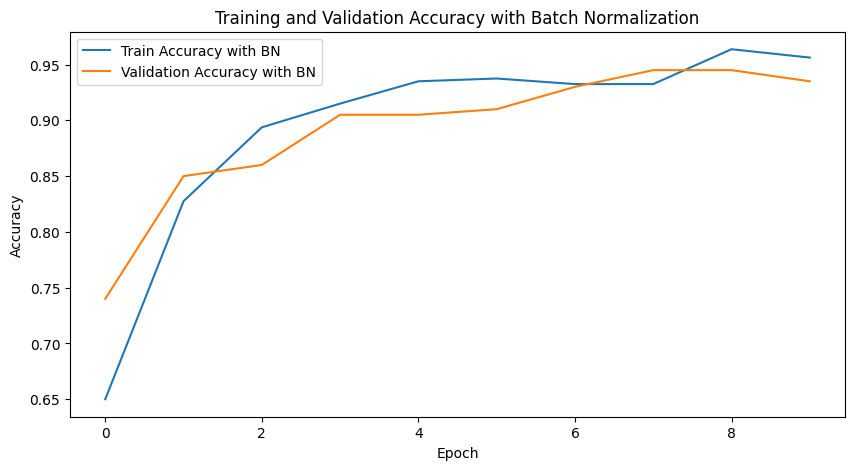

In [12]:
# Plotting the accuracy
plt.figure(figsize=(10, 5))
plt.plot(history_bn.history['accuracy'], label='Train Accuracy with BN')
plt.plot(history_bn.history['val_accuracy'], label='Validation Accuracy with BN')
plt.title('Training and Validation Accuracy with Batch Normalization')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# g) custsom dropout, custom regularization

In [20]:
# Custom Regularizer and Dropout
class CustomDropout(tf.keras.layers.Layer):
    def __init__(self, rate, **kwargs):
        super(CustomDropout, self).__init__(**kwargs)
        self.rate = rate
        self.epoch = 0

    def call(self, inputs, training=None):
        if not training:
            return inputs
        epoch_dropout = self.rate + 0.01 * self.epoch
        epoch_dropout = min(epoch_dropout, 0.5)  # Cap dropout at 50%
        return tf.nn.dropout(inputs, rate=epoch_dropout)

    def on_epoch_end(self, epoch, logs=None):
        self.epoch += 1

class CustomRegularizer(tf.keras.regularizers.Regularizer):
    def __init__(self, strength, set_point=0.0):
        self.strength = strength
        self.set_point = set_point

    def __call__(self, x):
        return self.strength * tf.reduce_sum(tf.abs(x - self.set_point))

# Build the model
model = Sequential([
    Dense(64, activation='relu', input_shape=(20,), kernel_regularizer=CustomRegularizer(0.01)),
    CustomDropout(0.1),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Epoch 1/30
25/25 [==============================] - 1s 18ms/step - loss: 2.2458 - accuracy: 0.6325 - val_loss: 2.1057 - val_accuracy: 0.7000
Epoch 2/30
25/25 [==============================] - 0s 6ms/step - loss: 1.9774 - accuracy: 0.7475 - val_loss: 1.8596 - val_accuracy: 0.7950
Epoch 3/30
25/25 [==============================] - 0s 5ms/step - loss: 1.7396 - accuracy: 0.8125 - val_loss: 1.6436 - val_accuracy: 0.8400
Epoch 4/30
25/25 [==============================] - 0s 7ms/step - loss: 1.5385 - accuracy: 0.8562 - val_loss: 1.4508 - val_accuracy: 0.8600
Epoch 5/30
25/25 [==============================] - 0s 7ms/step - loss: 1.3522 - accuracy: 0.8838 - val_loss: 1.2759 - val_accuracy: 0.8900
Epoch 6/30
25/25 [==============================] - 0s 5ms/step - loss: 1.1834 - accuracy: 0.9100 - val_loss: 1.1211 - val_accuracy: 0.9000
Epoch 7/30
25/25 [==============================] - 0s 4ms/step - loss: 1.0378 - accuracy: 0.9150 - val_loss: 0.9891 - val_accuracy: 0.9150
Epoch 8/30
25/25 [=

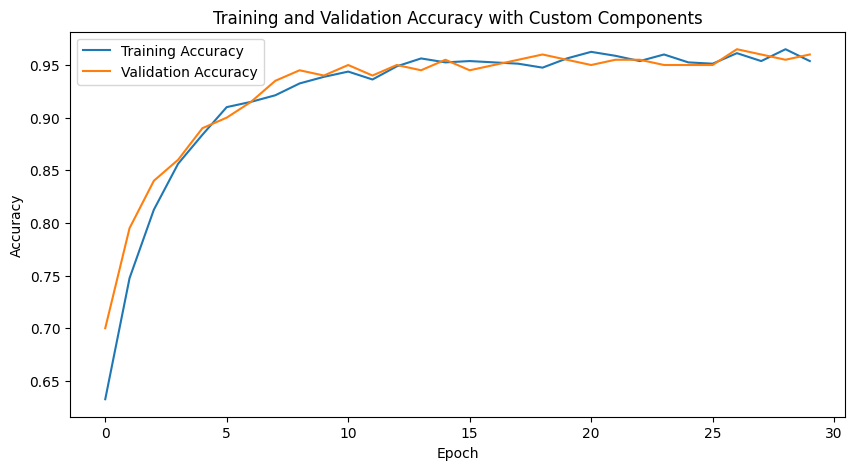

In [21]:
# Training the model
history = model.fit(data, labels, epochs=30, validation_split=0.2, verbose=1)

# Plotting the training and validation accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy with Custom Components')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# h) using callbacks and tensorboard

In [23]:
#Prepare the Data
np.random.seed(0)

data = np.random.randn(1000, 20)
labels = (np.sum(data, axis=1) > 0).astype(int)

In [24]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(20,)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [29]:
# Directory where the logs will be stored
log_dir = os.path.join("logs", "fit", datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [30]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)

In [31]:
history = model.fit(data, labels, epochs=100, validation_split=0.2, callbacks=[early_stopping, model_checkpoint, tensorboard_callback], verbose=1)

Epoch 1/100
22/25 [=========================>....] - ETA: 0s - loss: 0.6097 - accuracy: 0.6790
Epoch 1: val_accuracy improved from -inf to 0.78500, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 2s 31ms/step - loss: 0.6063 - accuracy: 0.6875 - val_loss: 0.5481 - val_accuracy: 0.7850
Epoch 2/100
16/25 [==================>...........] - ETA: 0s - loss: 0.4895 - accuracy: 0.8242
Epoch 2: val_accuracy improved from 0.78500 to 0.87000, saving model to best_model.h5
25/25 [==============================] - 0s 11ms/step - loss: 0.4571 - accuracy: 0.8413 - val_loss: 0.4185 - val_accuracy: 0.8700
Epoch 3/100
20/25 [=======================>......] - ETA: 0s - loss: 0.3234 - accuracy: 0.9094
Epoch 3: val_accuracy improved from 0.87000 to 0.92000, saving model to best_model.h5
25/25 [==============================] - 0s 8ms/step - loss: 0.3206 - accuracy: 0.9087 - val_loss: 0.2965 - val_accuracy: 0.9200
Epoch 4/100
18/25 [====================>.........] - ETA: 0s - loss: 0.2240 - accuracy: 0.9531
Epoch 4: val_accuracy improved from 0.92000 to 0.93500, saving model to best_model.h5
25/25 [==============================] - 0s 9ms/step - loss: 0.2174 

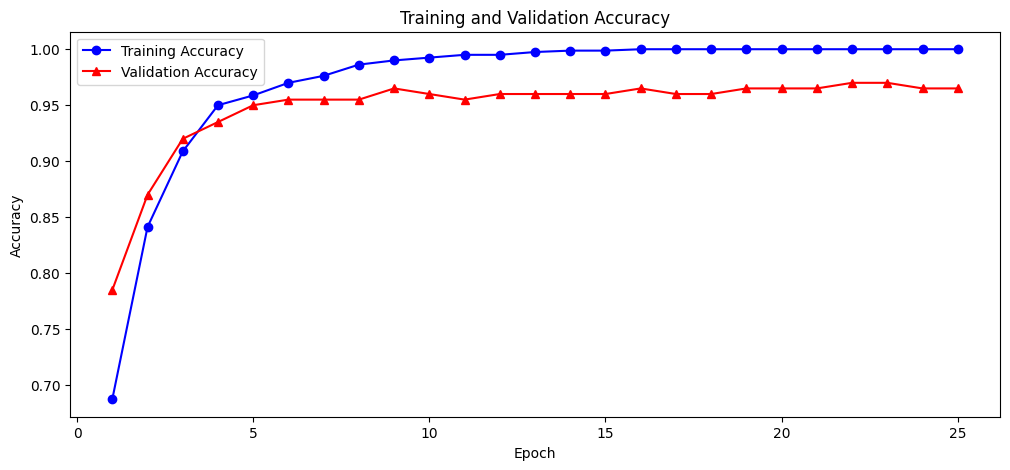

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))

plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r^-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# i) using keras tuner

In [ ]:
# Load the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

# Reshape the images to match the input shape of the model
train_images = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))

# Flatten the images to 1D arrays
train_images = train_images.reshape((60000, 784))
test_images = test_images.reshape((10000, 784))

# Convert labels to one-hot encoding for multi-class classification
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

# Split the data into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
from keras_tuner import RandomSearch
import keras

def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.Dense(units=hp.Int('units', min_value=32, max_value=512, step=32),
                                 activation='relu', input_shape=(784,)))
    model.add(keras.layers.Dense(10, activation='softmax')) # Adjusted for multi-class classification
    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='categorical_crossentropy', # Adjusted for multi-class classification
        metrics=['accuracy']
    )
    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10, # Set the number of experiments to perform
    executions_per_trial=1,
    directory='my_dir', # Directory to store the logs
    project_name='keras_tuner_demo'
)

tuner.search(train_images, train_labels, epochs=10, validation_data=(val_images, val_labels))
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()
loss, accuracy = best_model.evaluate(test_images, test_labels)
print(f'Loss: {loss}, Accuracy: {accuracy}')

Trial 10 Complete [00h 01m 38s]
val_accuracy: 0.981333315372467

Best val_accuracy So Far: 0.981416642665863
Total elapsed time: 00h 19m 59s
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 320)               251200    
                                                                 
 dense_1 (Dense)             (None, 10)                3210      
                                                                 
Total params: 254410 (993.79 KB)
Trainable params: 254410 (993.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
313/313 [==============================] - 1s 3ms/step - loss: 0.0763 - accuracy: 0.9794
Loss: 0.07630957663059235, Accuracy: 0.9793999791145325


# j) use keras cv data augmentation